In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import pandas as pd 
from scipy.spatial import ConvexHull
import math 

In [2]:
'''df = pd.read_csv("opendss.csv", delimiter=',', skiprows=0, low_memory=False)
df'''

'df = pd.read_csv("opendss.csv", delimiter=\',\', skiprows=0, low_memory=False)\ndf'

In [72]:
model = AbstractModel()
model.i = RangeSet(1,8)
model.j = RangeSet(1,3)
model.t = RangeSet(1,18)

model.X = Var(model.i,model.j,model.t, within=Binary)
model.Nshift= Var( within=NonNegativeReals)

def Rule_C1(model,t,j):
    return sum(model.X[i,j,t] for i in model.i)==3
model.C1=Constraint(model.t,model.j,  rule=Rule_C1)

def Rule_CA(model,t,i):
    return sum(model.X[i,j,t] for j in model.j)<=2
model.CA=Constraint(model.t,model.i,  rule=Rule_CA)

def Rule_CB(model,t,i):
    return sum(model.X[i,j,t] for j in model.j)>=1
model.CB=Constraint(model.t,model.i,  rule=Rule_CB)

def Rule_C2(model,t,i):
    if t<18:
        return model.X[i,3,t]+ model.X[i,3,t+1] <=1
    else:
        return Constraint.Skip
model.C2=Constraint(model.t,model.i,  rule=Rule_C2)

def Rule_C3(model,t,i):
    if t<18:
        return model.X[i,3,t]+ model.X[i,1,t+1] <=1
    else:
        return Constraint.Skip
model.C3=Constraint(model.t,model.i,  rule=Rule_C3)

def Rule_C4(model,i):
    return sum(model.X[i,3,t] for t in model.t)  <=model.Nshift
model.C4=Constraint(model.i,  rule=Rule_C4)

def rule_OF(model):
    #return quicksum(model.X[i,j,t] for i in model.i for j in model.j for t in model.t )
    return model.Nshift+quicksum(model.X[i,j,t] for i in model.i for j in model.j for t in model.t ) 
model.obj1 = Objective(rule=rule_OF, sense=minimize)

opt = SolverFactory('gurobi')
instance = model.create_instance()
results = opt.solve(instance) # solves and updates instance
print('OF= ',value(instance.obj1))
print ("The solver returned a status of:"+str(results.solver.status))
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print (str(results.solver))
        
print('Total = ',sum( value(instance.X[i,j,t]) for i in instance.i for j in instance.j for t in instance.t ))       
        

OF=  169.0
The solver returned a status of:ok
this is feasible and optimal
Total =  162.0


1 7.0
2 7.0
3 7.0
4 7.0
5 6.0
6 7.0
7 7.0
8 6.0


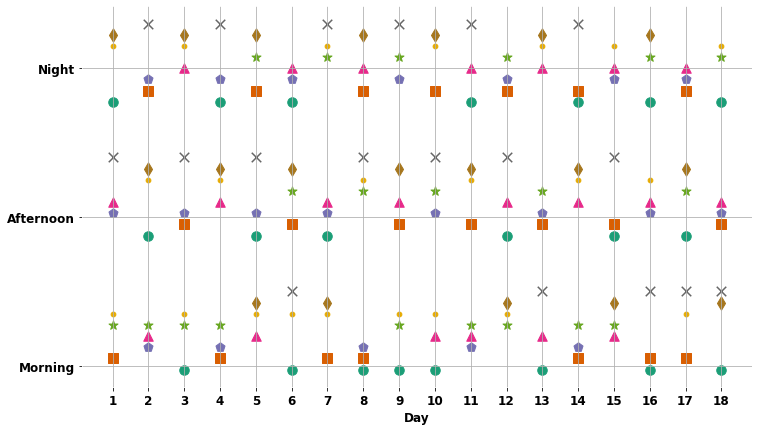

In [81]:
color=['r' ,'b','k','green','grey','yellow','brown' ,'k']
MK=['o','s','p','^','*','.','d','x','+']
cmap = plt.cm.Dark2  # define the colormap
color = [cmap(i) for i in range(20)]
plt.figure(figsize=(12,7) )
for t in instance.t:
    for i in instance.i:
        for j in instance.j:
            if value(instance.X[i,j,t])>0:
                #print(t,i,j)
                plt.scatter(t,1.8*j+0.15*i,s=90,color=color[i-1],marker=MK[i-1])
                
plt.xticks([i for i in range(1,19)], fontweight='bold', fontsize=12)

plt.yticks([i*2 for i in range(1,4)] ,['Morning', 'Afternoon', 'Night'] , fontweight='bold', fontsize=12)

for i in instance.i:
    print(i, sum(value(instance.X[i,j,t]) for t in instance.t) )
plt.xlabel('Day', fontweight='bold', fontsize=12)
plt.grid()
plt.rc('axes',edgecolor='w')
plt.savefig('ShiftStaff .png', format='png', bbox_inches='tight', dpi=400)
